In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cartopy.crs as ccrs

In [236]:
from tqdm import tqdm

In [3]:
%cd ..

/ships19/cloud/scratch/cphillips/isccp_l1g


In [4]:
import sys 
sys.path.append('/ships19/cloud/scratch/cphillips/utility')
from make_gif import make_video, render_fast, play_video

In [5]:
import xarray as xr

In [6]:
from pathlib import Path

In [7]:
import make_sample

(3, 3600, 7200)


In [8]:
AHI_PROJ = ccrs.Geostationary(140.7)

In [17]:
files = list(Path('l1b/2020/202007/20200701/20200701T0000/h8/temp_10_40um/').glob('*'))

In [18]:
scene, area = make_sample.read_scene(files, None)

In [ ]:
scene.

In [375]:
search = scene[2000:2512,2000:2512].load().values

In [596]:
tile = scene[2256:2512,2512:2512+256].load().values
search=tile

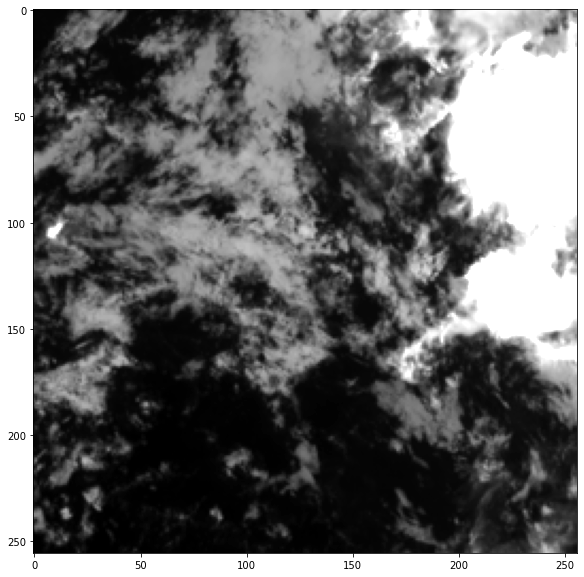

In [597]:
figure(figsize=(12,10))
imshow(tile, cmap='binary', vmin=250, vmax=296)

In [598]:
s = 2
canvas = np.full((256*s,256*s), np.nan, dtype=np.float64)
canvas_x,canvas_y = np.meshgrid(np.arange(256*s), np.arange(256*s),copy=False)
# added = 0
# for _ in range(1000):
#     rand_i,rand_j = np.unravel_index(np.random.randint(0,250*250), (250,250))
#     if mask[rand_i,rand_j]:
#         add_ball(canvas, (rand_j*s,rand_i*s),10*s)
#         added += 1
# added

In [599]:
t = torch.from_numpy(search[np.newaxis,np.newaxis].astype(np.float32))

In [600]:
weights = torch.from_numpy(np.full((1,1,s,s),1/(s*s), dtype=np.float32))

In [601]:
double_coarse = F.conv2d(t, weights, padding='valid')[:,:,:-1,:-1]
#double_coarse = double_coarse.reshape(s*s, 1, int(double_coarse.shape[-2]/s), int(double_coarse.shape[-1]/s))

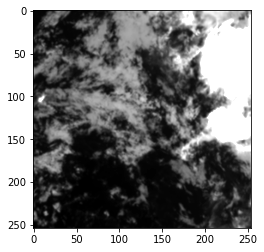

In [602]:
imshow(double_coarse.squeeze().numpy(), vmin=250, vmax=296, cmap='binary')

In [603]:
import torch
import torch.nn
import torch.nn.functional as F

In [590]:
(template0-search0)**2 + (template1-search1)**2 + (template2-search2)**2 + (template3-search3)**4
template0**2 + template1**2 + template2**2 + template3**2 
#const
- 2*search0*template0 - 2*search1*template1 - 2*search2*template2 - 2*search3*template3
# -2 conv2x2(search, template)
+ search0**2 + search1**2 + search2**2  + search3**2
# conv2x2(search**2)

NameError: name 'template0' is not defined

In [604]:
with torch.no_grad():
    search_conv = torch.nn.Conv2d(1,1,3,dilation=s,padding='valid',bias=False)
    search_conv.requires_grad=False

In [605]:
with torch.no_grad():
    add_conv = torch.nn.Conv2d(1,1,3,dilation=s,padding='valid',bias=False)
    add_conv.requires_grad=False
    add_conv.weight[:] = 1
    double_course_sqr_sum = add_conv(double_coarse**2)

In [606]:
min_cutoff, max_cutoff = np.nanpercentile(double_coarse, [5,95])

In [628]:
with tqdm(np.arange(1,256-1)) as bar:
    for i in bar:
        for j in np.arange(1,256-1):
            template_3x3 = torch.from_numpy(tile[i-1:i+2,j-1:j+2])[None,None]
#             if (template_3x3 > max_cutoff).any() or (template_3x3 < min_cutoff).any():
#                 continue
            with torch.no_grad():
                search_conv.weight[:] = template_3x3
                d = double_course_sqr_sum - 2*search_conv(double_coarse) + (template_3x3**2).sum()
                _,_,best_i,best_j = np.unravel_index(d.argmin(), d.shape)
            subi = slice(best_i+s, best_i+2*s)
            subj = slice(best_j+s, best_j+2*s)
            sub_tile = search[subi,subj]
            canvas[i*s:(i+1)*s,j*s:(j+1)*s] = 1.4*(sub_tile - sub_tile.mean())+sub_tile.mean()
            #break
        #break

100%|██████████| 254/254 [01:32<00:00,  2.75it/s]


In [638]:
import PIL.Image

In [649]:
def make_image(x):
    scaled = (np.nan_to_num(x).clip(200,296)-200)/(296-200)*255
    return PIL.Image.fromarray(255 - scaled.astype(np.uint8))

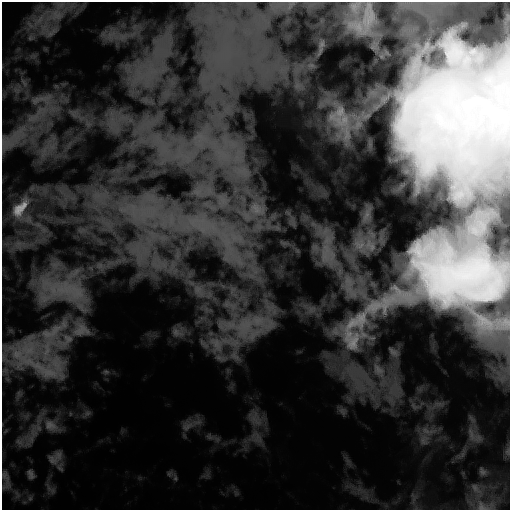

In [684]:
sr_image = make_image(canvas[:,:])
sr_image

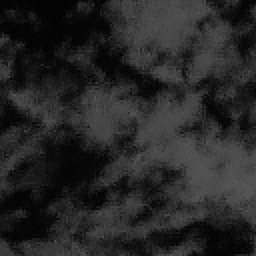

In [700]:
sr_image.crop((64,64,64+128,64+128)).resize((256,256), resample=PIL.Image.NEAREST)

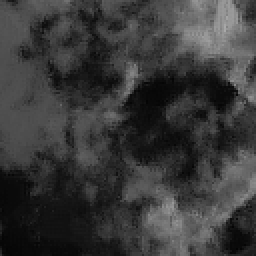

In [689]:
sr_image.crop((256,8,256+128,128+8)).resize((256,256), resample=PIL.Image.NEAREST)

In [696]:
orig_im = make_image(tile)
orig_im = orig_im.resize((512,512), resample=PIL.Image.NEAREST)

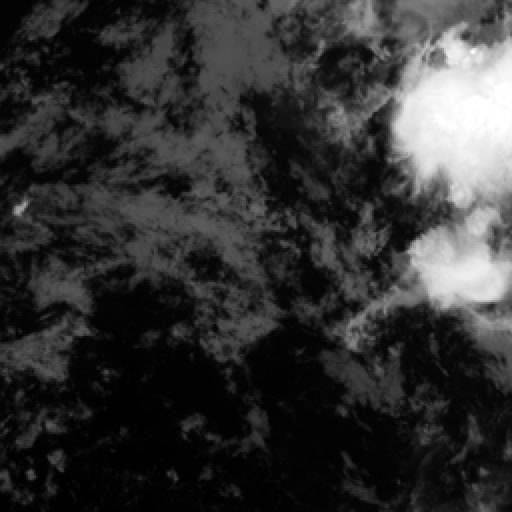

In [705]:
orig_im

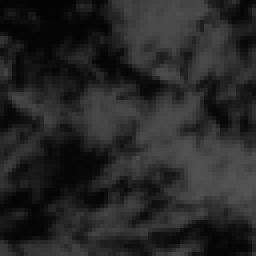

In [703]:
orig_im.crop((64,64,64+128,64+128)).resize((256,256), resample=PIL.Image.NEAREST)

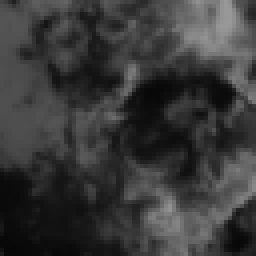

In [704]:
orig_im.crop((256,8,256+128,128+8)).resize((256,256), resample=PIL.Image.NEAREST)

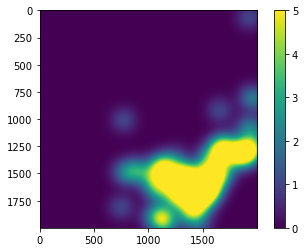

In [149]:
imshow(canvas.clip(0,5))
colorbar()

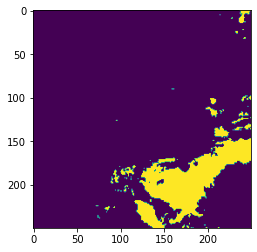

In [114]:
imshow(mask)

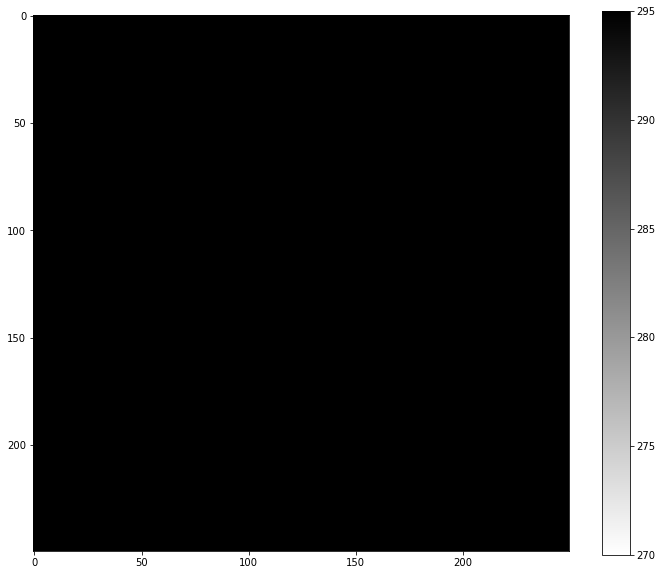

In [52]:
figure(figsize=(12,10))
imshow(synth, vmin=270, vmax=295, cmap='binary')
colorbar()

(array([1282., 1398., 1736., 1857., 2273., 2486., 2367., 2807., 3166.,
        3696., 3486., 3821., 3928., 3964., 4610., 6755., 1112.,    0.,
           0.,    0.]),
 array([280., 281., 282., 283., 284., 285., 286., 287., 288., 289., 290.,
        291., 292., 293., 294., 295., 296., 297., 298., 299., 300.],
       dtype=float32),
 <BarContainer object of 20 artists>)

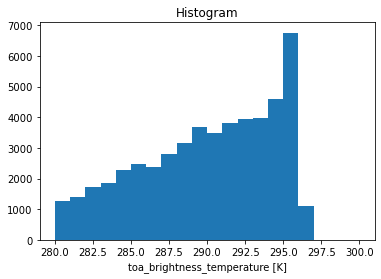

In [25]:
tile[:250,-250:].plot.hist(range=(280,300), bins=20)